In [1]:
from __future__ import absolute_import, division, print_function
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from metric_utils import *

## Predictions Format

The model accepts predictions as JSON files in the following format
(The notation in caps with a dollar sign (`$IMG_NAME`) means that such key will be replaced by the actual value of the property)
```json
    {
        "$IMG_NAME": {
            "labels": [$CLASS_NAME: string, ..., $CLASS_NAME: string],
            "boxes": [[$X1, $Y1, $X2, $Y2], ..., [$X1, $Y1, $X2, $Y2]],
            "scores": [$CONFIDENCE_SCORE: float, ..., $CONFIDENCE_SCORE: float]
        },

        ...
        
        "$IMG_NAME": {
            "labels": [$CLASS_NAME: string, ..., $CLASS_NAME: string],
            "boxes": [[$X1, $Y1, $X2, $Y2], ..., [$X1, $Y1, $X2, $Y2]],
            "scores": [$CONFIDENCE_SCORE: float, ..., $CONFIDENCE_SCORE: float]
        }
    }
```

## Ground Truth Format

Same as before, without the scores
```json
    {
        "$IMG_NAME": {
            "labels": [$CLASS_NAME: string, ..., $CLASS_NAME: string],
            "boxes": [[$X1, $Y1, $X2, $Y2], ..., [$X1, $Y1, $X2, $Y2]],
        },

        ...
        
        "$IMG_NAME": {
            "labels": [$CLASS_NAME: string, ..., $CLASS_NAME: string],
            "boxes": [[$X1, $Y1, $X2, $Y2], ..., [$X1, $Y1, $X2, $Y2]],
        }
    }
```

## Visualization setup

In [2]:
sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

## Loading gt and pred annotations

In [3]:
# gt_file = 'gt_boxes_1im.json'
# pred_file = 'rg-boxes_1im.json'
# gt_file = 'gt_boxes.json'
# pred_file = 'rg-boxes@0.9cs.json'
# gt_file = 'gt_less_5.json'
# pred_file = 'pred_less_5.json'
# gt_file = 'gt_5_to_20.json'
# pred_file = 'pred_5_to_20.json'
gt_file = 'sample_jsons/ground_truth_boxes.json'
pred_file = 'sample_jsons/predicted_boxes.json'

with open(gt_file) as infile:
    gt_boxes = json.load(infile)

with open(pred_file) as infile:
    pred_boxes = json.load(infile)

class_name_to_idx = {
    'background': 0,
    'sidelobe': 1,
    'source': 2,
    'galaxy': 3,
}

In [4]:
no_pred = []
for img in gt_boxes:
    if img not in pred_boxes:
        print(f'Image {img} not in predicted images, skipping')
        no_pred.append(img)

for img in no_pred:
    del gt_boxes[img]

In [5]:
gt_boxes_source, pred_boxes_source = split_boxes_by_class(gt_boxes, pred_boxes, 'source')
gt_boxes_sidelobe, pred_boxes_sidelobe = split_boxes_by_class(gt_boxes, pred_boxes, 'sidelobe')
gt_boxes_galaxy, pred_boxes_galaxy = split_boxes_by_class(gt_boxes, pred_boxes, 'galaxy')

## mAP@0.5

In [6]:
# Run per class mAP calculation for each class
iou_thr = 0.5
# calculate source mAP
data = get_avg_precision_at_iou(gt_boxes_source, pred_boxes_source, iou_thr=iou_thr)
print('Source avg precision: {:.4f}'.format(data['avg_prec']))
# calculate sidelobe mAP
data = get_avg_precision_at_iou(gt_boxes_sidelobe, pred_boxes_sidelobe, iou_thr=iou_thr)
print('Sidelobe avg precision: {:.4f}'.format(data['avg_prec']))
# calculate galaxy mAP
data = get_avg_precision_at_iou(gt_boxes_galaxy, pred_boxes_galaxy, iou_thr=iou_thr)
print('Galaxy avg precision: {:.4f}'.format(data['avg_prec']))

# Runs it for one IoU threshold for all predictions
start_time = time.time()
data = get_avg_precision_at_iou(gt_boxes, pred_boxes.copy(), iou_thr=iou_thr)
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))

Source avg precision: 0.6899
Sidelobe avg precision: 0.2407
Galaxy avg precision: 0.7062
Single IoU calculation took 2.0387 secs
avg precision: 0.7023


## mAP@0.5:0.95 + Reliability-Completeness (RC) (Precision-Recall (PR)) Curve

map: 44.33
avg precs:  [0.7023, 0.69, 0.6743, 0.6431, 0.5579, 0.443, 0.3259, 0.2351, 0.1277, 0.0338]
iou_thrs:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Plotting and calculating mAP takes 19.7880 secs


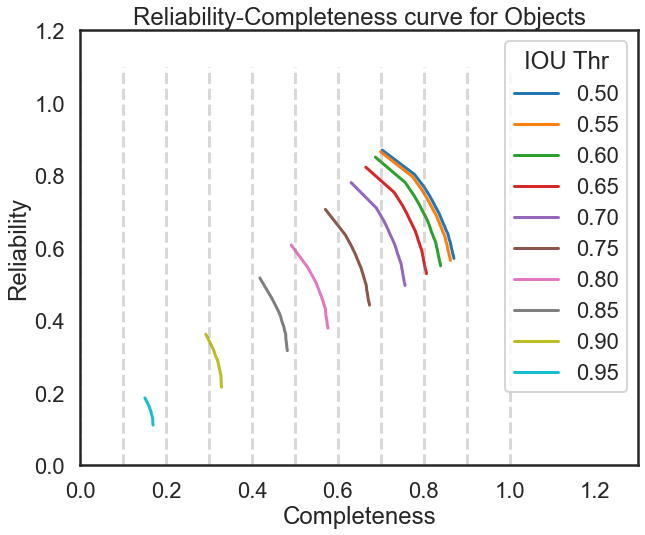

In [7]:
start_time = time.time()
ax = None
avg_precs = []
iou_thrs = []
for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    avg_precs.append(data['avg_prec'])
    iou_thrs.append(iou_thr)

    precisions = data['precisions']
    recalls = data['recalls']
    ax = plot_pr_curve(
        precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

# prettify for printing:
avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

## Plot RC (PR) Curve per class

map: 53.05
avg precs:  [0.6899, 0.6691, 0.2407, 0.1773, 0.7062, 0.6998]
iou_thrs:   [0.5, 0.6, 0.5, 0.6, 0.5, 0.6]

Plotting and calculating mAP takes 3.4686 secs


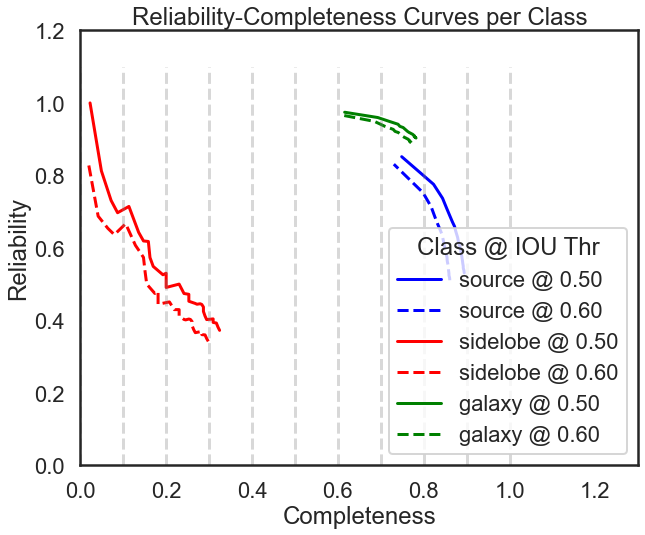

In [8]:
# Super-Imposed per Class
start_time = time.time()
ax = None
avg_precs = []
iou_thrs = []
classes = ['source', 'sidelobe', 'galaxy']
for i, classification in enumerate(classes):
    for iou_thr in np.linspace(0.5, 0.6, 2):
        if classification == 'source':
            data = get_avg_precision_at_iou(gt_boxes_source, pred_boxes_source, iou_thr=iou_thr)
            colour = 'blue'
        elif classification == 'sidelobe':
            data = get_avg_precision_at_iou(gt_boxes_sidelobe, pred_boxes_sidelobe, iou_thr=iou_thr)
            colour = 'red'
        elif classification == 'galaxy':
            data = get_avg_precision_at_iou(gt_boxes_galaxy, pred_boxes_galaxy, iou_thr=iou_thr)
            colour = 'green'
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)

        precisions = data['precisions']
        recalls = data['recalls']

        if iou_thr == 0.5:
            line_style = 'solid'
        elif iou_thr == 0.6:
            line_style = 'dashed'
        # ax = plot_pr_curve(precisions, recalls, label=classification+' @ {:.2f}'.format(iou_thr),
        #                    color=COLORS[i*len(classes) + j], ax=ax)
        ax = plot_pr_curve(precisions, recalls, label=classification + ' @ {:.2f}'.format(iou_thr),
                            color=colour, ax=ax, linestyle=line_style)


# prettify for printing:
avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100 * np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.title('Reliability-Completeness Curves per Class')
plt.xlabel('Completeness')
plt.ylabel('Reliability')
plt.legend(loc='lower right', title='Class @ IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

## Calculate TP, FP, FN, TN, Reliability (Precision), Completeness (Recall), and F1-Score

In [9]:
# Adapted from https://github.com/SKA-INAF/mrcnn/blob/master/mrcnn/analyze.py lines 1,200-1,340
from typing import List
import copy


def get_iou(gt_box, pred_box) -> float:
    gt_box_x1, gt_box_y1, gt_box_x2, gt_box_y2 = gt_box
    pred_box_x1, pred_box_y1, pred_box_x2, pred_box_y2 = pred_box
    
    x_left = max(gt_box_x1, pred_box_x1)
    x_right = min(gt_box_x2, pred_box_x2)
    y_top = max(gt_box_y1, pred_box_y1)
    y_bottom = min(gt_box_y2, pred_box_y2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area: float = (x_right - x_left) * (y_bottom - y_top)
        
    # compute the area of both AABBs
    gt_box_area: float = (gt_box_x2 - gt_box_x1) * (gt_box_y2 - gt_box_y1)
    pred_box_area: float = (pred_box_x2 - pred_box_x1) * (pred_box_y2 - pred_box_y1)
        
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou: float = intersection_area / float(gt_box_area + pred_box_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0

    return iou


iou_thr: float = 0.6

# [_, sidelobes, sources, galaxies]
class_count: int = 3

true: np.ndarray = np.zeros((1, class_count+1))
pos: np.ndarray = np.zeros((1, class_count+1))
    
confusion_matrix: np.ndarray = np.zeros((class_count+1, class_count+1))
    
true_positives: np.ndarray = np.zeros((1, class_count+1))
false_positives: np.ndarray = np.zeros((1, class_count+1))
false_negatives: np.ndarray = np.zeros((1, class_count+1))
true_negatives: np.ndarray = np.zeros((1, class_count+1))
    
reliability: np.ndarray = np.zeros((1, class_count+1))
completeness: np.ndarray = np.zeros((1, class_count+1))
f1_score: np.ndarray = np.zeros((1, class_count+1))

# Loop over all of the images
for i, gt_box_key in enumerate(gt_boxes.keys()):
    if gt_box_key not in pred_boxes.keys():
        c = 2
    assert gt_box_key in pred_boxes.keys()
    
    # Loop over all of the ground truth objects for the current image
    for i, (gt_box, gt_label) in enumerate(zip(gt_boxes[gt_box_key]['boxes'], gt_boxes[gt_box_key]['labels'])):     
        # increment true count for the object
        gt_label_idx = class_name_to_idx[gt_label]
        true[0][gt_label_idx] += 1
        
        # Find associations between true and detected objects according to largest IOU
        index_best: int = -1
        iou_best: float = 0
        score_best: float = 0
        
        # iterate over every detected object for the current image
        for j, (pred_box, pred_label, pred_score) in enumerate(zip(pred_boxes[gt_box_key]['boxes'], pred_boxes[gt_box_key]['labels'], pred_boxes[gt_box_key]['scores'])):
            # calculate the IoU of the ground truth and detection bounding boxes
            iou: float = get_iou(gt_box, pred_box)

            if iou > iou_thr and iou > iou_best: # and score threshold?
                index_best = j
                iou_best = iou
                score_best = pred_score
             
        # if a match was found
        if index_best != -1:
            det_label = pred_boxes[gt_box_key]['labels'][index_best]
            det_label_idx = class_name_to_idx[det_label]
            
            # confusion matrix (for True Negatives)
            confusion_matrix[gt_label_idx][det_label_idx] += 1
            
            # for True Positives
            # if the detection's label is correct (matches that of the ground truth)
            if gt_label == det_label:
                # increment the TP count for that label/class
                true_positives[0][gt_label_idx] += 1

                
# Display Results
print('\t\t\t[sidelobes, sources, galaxies]')

# True
print('True:\t\t\t', true[:, 1:])

# Pos (Detections) (TP + FP)
# iterate over every detected object in every image
for pred_box_key in pred_boxes.keys():
    for pred_label in pred_boxes[pred_box_key]['labels']:
        # increment pos count for the detection
        pred_label_idx = class_name_to_idx[pred_label]
        pos[0][pred_label_idx] += 1
print('Positive Detections:\t', pos[:, 1:])


# Confusion Matrix
print('Confusion Matrix:\n', confusion_matrix[1:, 1:])


# True Positives
print('True Positives:\t\t', true_positives[:, 1:])
                
# False Positives:
false_positives = pos - true_positives
print('False Positives:\t', false_positives[:, 1:])

# False Negatives:
false_negatives = true - true_positives
print('False Negatives:\t', false_negatives[:, 1:])

# True Negatives
# The model doesn't make negative predictions, so it doesn't make much sense to include a TN count.
for i in range(1, class_count+1):
    confusion_matrix_class = copy.deepcopy(confusion_matrix)
    confusion_matrix_class = np.delete(confusion_matrix_class, i, 0)
    confusion_matrix_class = np.delete(confusion_matrix_class, i, 1)
    true_negative_class = np.sum(confusion_matrix_class)
    true_negatives[0][i] = true_negative_class
print('True Negatives:\t\t', true_negatives[:, 1:])


# Reliability
for i, (true_positive_class, pos_class) in enumerate(zip(true_positives[0], pos[0])):
    if pos_class == 0:
        continue
    reliability_class: float = true_positive_class / pos_class
    reliability[0][i] = reliability_class
print('Reliability:\t\t', reliability[:, 1:])

# Completeness
for i, (true_positive_class, true_class) in enumerate(zip(true_positives[0], true[0])):
    if true_class == 0:
        continue
    completeness_class: float = true_positive_class / true_class
    completeness[0][i] = completeness_class
print('Completeness:\t\t', completeness[:, 1:])

# F1-Score
# f1_score = 2 * ((reliability * completeness) / (reliability + completeness))
for i, (reliability_class, completeness_class) in enumerate(zip(reliability[0], completeness[0])):
    if (reliability_class + completeness_class) == 0:
        continue
    f1_score_class: float = 2 * ((reliability_class * completeness_class) / (reliability_class + completeness_class))
    f1_score[0][i] = f1_score_class
print('F1-Score:\t\t', f1_score[:, 1:])

# Overall Metrics
print('Overall Metrics for All Classes')

overall_reliability: float = true_positives.sum() / pos.sum()
print(f'Reliability:\t{overall_reliability:.4f}')

overall_completeness: float = true_positives.sum() / true.sum()
print(f'Completeness:\t{overall_completeness:.4f}')

overall_f1_score: float = 2 * ((overall_reliability * overall_completeness) / (overall_reliability + overall_completeness))
print(f'F1-Score:\t{overall_f1_score:.4f}')

			[sidelobes, sources, galaxies]
True:			 [[ 265. 5857. 1166.]]
Positive Detections:	 [[ 232. 9898. 1011.]]
Confusion Matrix:
 [[  76.   29.    0.]
 [   0. 4818.   25.]
 [   0.   42.  898.]]
True Positives:		 [[  76. 4818.  898.]]
False Positives:	 [[ 156. 5080.  113.]]
False Negatives:	 [[ 189. 1039.  268.]]
True Negatives:		 [[5783.  974. 4923.]]
Reliability:		 [[0.32758621 0.486765   0.88822948]]
Completeness:		 [[0.28679245 0.82260543 0.77015437]]
F1-Score:		 [[0.30583501 0.61161536 0.82498852]]
Overall Metrics for All Classes
Reliability:	0.5199
Completeness:	0.7947
F1-Score:	0.6286


## Image Visualization

In [14]:
pred_boxes['sample20_galaxy0050'].keys()

dict_keys(['labels', 'boxes', 'scores'])

In [33]:
import torch
def log_image(pil_img, labels, boxes, confidence, title, CLASSES, COLORS):

    fig = plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()

    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()
    if isinstance(confidence, torch.Tensor):
        confidence = confidence.tolist()

    try:
        for cl, (xmin, ymin, xmax, ymax), cs, in zip(labels, boxes, confidence):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=COLORS[cl], linewidth=3))
            text = f'{CLASSES[cl]}: {cs:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    except Exception as e:
        print(e)
    finally:
        plt.axis('off')
        return fig
        
def log_gt(pil_img, labels, boxes, title, CLASSES, COLORS):

    fig = plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()

    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()

    try:
        for cl, (xmin, ymin, xmax, ymax) in zip(labels, boxes):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=COLORS[cl], linewidth=3))
            text = f'{CLASSES[cl]}: GT'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='red', alpha=0.5))
    except Exception as e:
        print(e)
    finally:
        plt.axis('off')
        return fig

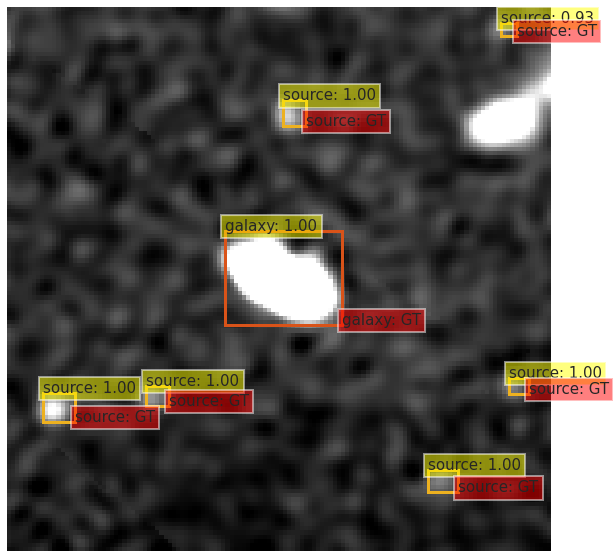

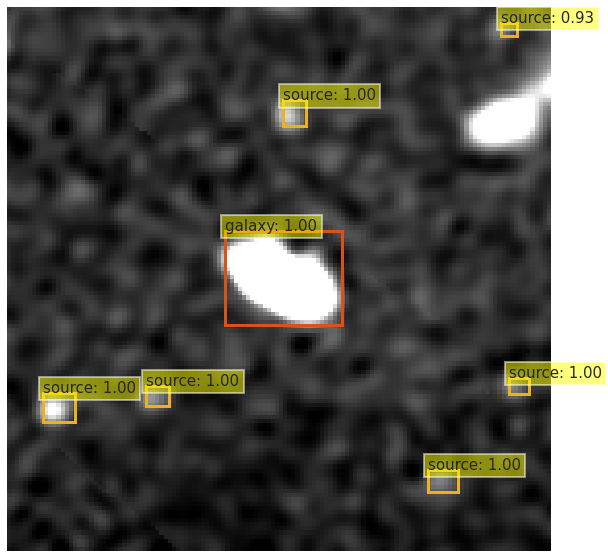

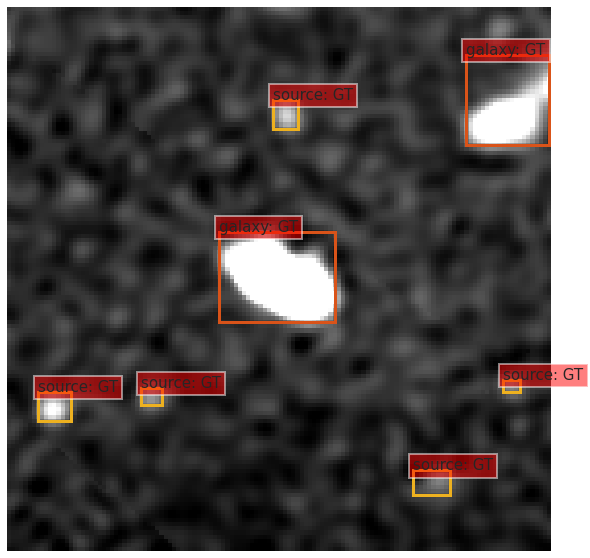

In [34]:
from pathlib import Path
from PIL import Image
CLASSES = ['No-Object', 'galaxy', 'source', 'sidelobe']
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556]]

img_name =  'sample20_galaxy0050'

img_path = Path(f'/home/rensortino/INAF/detr/data/radio-galaxy/test/{img_name}.png')

gt_bb, gt_lbl = gt_boxes[img_name]['boxes'], gt_boxes[img_name]['labels']
pred_bb, pred_lbl, pred_scores = pred_boxes[img_name]['boxes'], pred_boxes[img_name]['labels'], pred_boxes[img_name]['scores']

gt_lbl = [class_name_to_idx[name] for name in gt_lbl ]
pred_lbl = [class_name_to_idx[name] for name in pred_lbl ]

pil_img = Image.open(img_path).convert("RGB")

fig = log_image(pil_img, pred_lbl, pred_bb, pred_scores, 'Prediction', CLASSES, COLORS)
fig = log_gt(pil_img, gt_lbl, gt_bb, 'GT', CLASSES, COLORS)